Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

In [24]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

### Load Competition Data

In [3]:
import pandas as pd

# You may need to change the path
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(train.shape, test.shape)

(4087, 3) (1022, 2)


In [4]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [5]:
# Distribution of ratingCategory: 0 (Excellent), 1 (Good), 2 (Poor)
train.ratingCategory.value_counts()

1    2881
0    1141
2      65
Name: ratingCategory, dtype: int64

In [6]:
from explore_data import *
import seaborn as sns
sns.set()

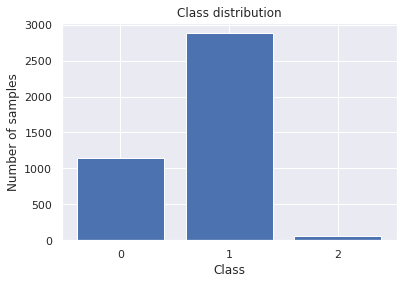

In [7]:
plot_class_distribution(train.ratingCategory)

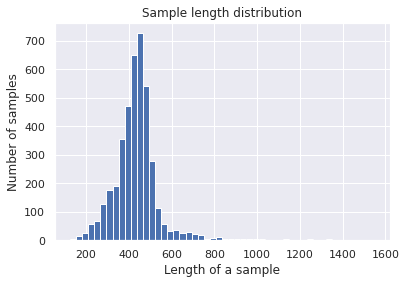

In [19]:

plot_sample_length_distribution(train['description'])

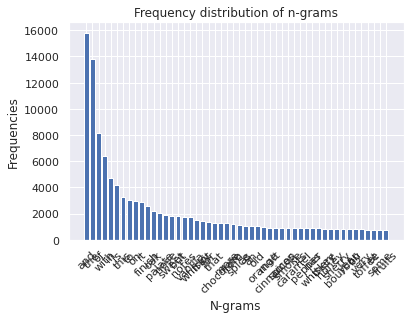

In [20]:
plot_frequency_distribution_of_ngrams(train['description'],
                                      ngram_range=(1,2),
                                      num_ngrams=50)

## Read the Reviews - SMELL TEST

In [9]:
# Read a few reviews from the "Excellent" category
pd.set_option('display.max_colwidth', 0)
train[train.ratingCategory == 0].sample(3)

,id,description,ratingCategory
482,3943,"\nThis summons up plenty of snappy grain notes, with green apple, melon rind, and zested lemon bumping into dried chili, green tomato, damp hay bales, and a dose of spice. It’s sweeter than a kitten with a ball of wool: lemon bonbons, toffee, vanilla cream, banana chews, zesty mandarin, apple, butterscotch, pepper, and clove. Sour apple pips, burnt sugar and spice, and some residual vanilla creaminess see it out.",0
4051,10,"\nCaptivating, enticing, and wonderfully charming, this first blended malt from Chivas Regal contains selections of five Speyside malts: Strathisla, Longmorn, Tormore, Allt-a-Bhainne, and Braeval. Red apple, cherry, raspberry fudge, peach and mango fruit salad, dusting of cinnamon, and dry heather sprigs. In essence, it’s rich and satisfying, with dark vanilla, apricot, Bourneville-covered Brazil nuts, and tangerine, smoothed over by caramel and wood spices, maltiness, and gingersnap biscuits. Quite heavenly. Editor's Choice",0
2784,4034,"\nFlorals and fruit begin a soft and delicate journey. For such a light whiskey, it’s certainly heavy on cherries, stone fruit, apples, and marmalade, followed by toffee, coffee, bananas, and chocolate. A drop of water shows how delicate it is, and the short finish suggests this whiskey would be leaps and bounds better with ten more degrees of proof.",0


In [11]:
# Read a few reviews from the "Poor" category
pd.set_option('display.max_colwidth', 0)
train[train.ratingCategory == 2].sample(3)

,id,description,ratingCategory
2906,5045,"\nMade from 100% rye, but aged in wine casks. Distinctly pink tinge: rosé whiskey. Very young nose: rye grain, Starburst candies, and feinty vegetable notes along with the wine-oak. Thin, dry, reminiscent of a dry hay barn: dusty grain, warm wood planks, a bit medicinal. Aged 130 days, and tastes like it. Growing up in Pennsylvania, Highspire was a town we stayed out of. Good advice.",2
3867,5091,"\nEarthy, fleshy notes with brooding grape notes and a gamey finish -- the Nebbiolo grape influence is obvious. I enjoy Barolo wine and I enjoy Edradour whisky, but the flavors in this whisky mix like oil and water. (Exclusive to Binny’s Beverage Depot.)",2
2032,5098,"\nI love Rogue beers, as well as Rogue’s attitude and philosophy. But this whiskey just tastes too immature—harsh, sweet, and one-dimensional. Maybe with some additional aging it might come around, mellow out, and develop, but it has a long way to go.",2


## Split the Training Set into Train/Validation

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['description'],
                                                    train['ratingCategory'],
                                                    test_size=0.2,
                                                    stratify=train['ratingCategory'],
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3269,) (818,) (3269,) (818,)


In [22]:
median_words_per_sample = get_num_words_per_sample(train['description'])
sw_ratio = len(train['description']) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 58


### Define Pipeline Components

In [25]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english',ngram_range=(1,2)) 
rfc = RandomForestClassifier()

In [27]:
import pandas as pd

# Get sparse dtm
dtm = vect.fit_transform(train['description'])

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(4087, 123012)

In [28]:
# Define the Pipeline
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', rfc)         # RandomForect Classifer
])

pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [56]:
parameters = {
    'vect__max_df': (.07, 1.0),
    'vect__min_df': (2, 4),
    'vect__max_features': (3000, 4000),
    'clf__n_estimators': (250, 300)}#,
    #'clf__max_depth': (8 ,None)}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train['description'], train['ratingCategory'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [57]:
grid_search.best_score_

0.7457814234796636

In [58]:
grid_search.best_params_

{'clf__n_estimators': 300,
 'vect__max_df': 1.0,
 'vect__max_features': 4000,
 'vect__min_df': 2}

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [59]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [60]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [61]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [43]:
subNumber = 0

In [62]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./data/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

You're trying to achieve a minimum of 70% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [ ]:
lsi = ...
vect = ...
clf = ...

pipe = Pipeline([('lsi', lsi), ('clf', clf)])

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [ ]:
parameters = {
    'lsi__svd__n_components': [10,100,250],
    'vect__max_df': (0.75, 1.0),
    'clf__max_depth':(5,10,15,20)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(..., ...)

### Make a Submission File

In [ ]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./data/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [ ]:
# Apply to your Dataset

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from scipy.stats import randint

param_dist = {
    
    'max_depth' : randint(3,10),
    'min_samples_leaf': randint(2,15)
}

In [ ]:
# Continue Word Embedding Work Here


### Make a Submission File

In [ ]:
# Predictions on test sample
pred = ...predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./data/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 70% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?